# Test

In [1]:
# Test

In [1]:
import pandas as pd

# 1. Load the forecast file
#    Download from: https://projects.fivethirtyeight.com/2023-nba-predictions/nba_elo_latest.csv
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])

# 2. Prepare a per-team, per-game index table
#    Assume df has columns: date, season, neutral, playoff, team1, team2,
#    elo1_pre, elo2_pre, elo_prob1, elo_prob2
games = (
    pd.concat([
        df.rename(columns={'team1':'team','elo_prob1':'win_prob'}),
        df.rename(columns={'team2':'team','elo_prob2':'win_prob'})
    ], ignore_index=True)
    .sort_values(['team','date'])
    .reset_index(drop=True)
)

# 3. Compute cumulative actual wins and expected remaining wins
results = []
for team, grp in games.groupby('team'):
    grp = grp.assign(
        actual_win = ( (grp['team']==grp['team1']) & (grp['score1']>grp['score2']) )
                   | ( (grp['team']==grp['team2']) & (grp['score2']>grp['score1']) )
    ).reset_index(drop=True)
    n = len(grp)
    for i in range(n):
        wins_so_far = grp.loc[:i, 'actual_win'].sum()
        exp_rem_wins = grp.loc[i+1:, 'win_prob'].sum()
        pred_wins = wins_so_far + exp_rem_wins
        results.append({
            'team': team,
            'game_idx': i+1,
            'date': grp.loc[i, 'date'],
            'predicted_wins': pred_wins,
            'predicted_losses': 82 - pred_wins
        })

pred_df = pd.DataFrame(results)

# 4. (Optional) Pivot for easy plotting
pivot = pred_df.pivot(index='game_idx', columns='team',
                     values='predicted_wins')


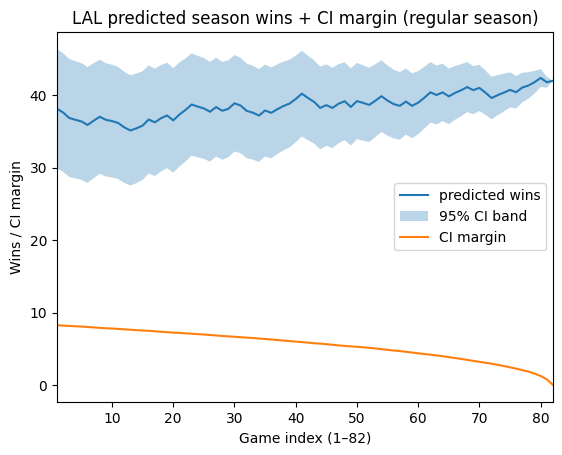

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# 1. Load the forecast data (ensure this file is in your working directory)
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])

# 2. Prepare per-team game-level data
games = pd.concat([
    df.rename(columns={'team1': 'team', 'elo_prob1': 'win_prob', 'score1': 'score', 'score2': 'opp_score'}),
    df.rename(columns={'team2': 'team', 'elo_prob2': 'win_prob', 'score2': 'score', 'score1': 'opp_score'})
], ignore_index=True).sort_values(['team', 'date']).reset_index(drop=True)

# 3. Compute actual wins
games['actual_win'] = (games['score'] > games['opp_score']).astype(int)

def plot_pred_with_ci_and_margin(team, z=1.96, max_games=82):
    grp = games[games['team'] == team].reset_index(drop=True)
    
    stats = []
    wins_so_far = 0
    for i in range(len(grp)):
        # Stop at the end of the 82-game regular season
        if i >= max_games:
            break
        
        if i > 0:
            wins_so_far += grp.loc[i-1, 'actual_win']
        
        # Future games only up to the 82nd matchup
        future = grp.loc[i+1:max_games-1, 'win_prob']
        exp_rem_wins = future.sum()
        var_rem = (future * (1 - future)).sum()
        
        pred_wins = wins_so_far + exp_rem_wins
        std_dev = sqrt(var_rem)
        ci_margin = z * std_dev
        
        stats.append({
            'game_idx': i + 1,
            'predicted_wins': pred_wins,
            'ci_margin': ci_margin
        })
    
    stats_df = pd.DataFrame(stats)
    
    # Plot predicted wins with confidence band and margin line, limited to 82 games
    plt.figure()
    plt.plot(stats_df['game_idx'], stats_df['predicted_wins'], label='predicted wins')
    plt.fill_between(
        stats_df['game_idx'],
        stats_df['predicted_wins'] - stats_df['ci_margin'],
        stats_df['predicted_wins'] + stats_df['ci_margin'],
        alpha=0.3,
        label='95% CI band'
    )
    plt.plot(stats_df['game_idx'], stats_df['ci_margin'], label='CI margin')
    plt.xlim(1, max_games)
    plt.xlabel('Game index (1–82)')
    plt.ylabel('Wins / CI margin')
    plt.title(f'{team} predicted season wins + CI margin (regular season)')
    plt.legend()
    plt.show()

# Example usage for Los Angeles Lakers
plot_pred_with_ci_and_margin('LAL', z=1.96, max_games=82)


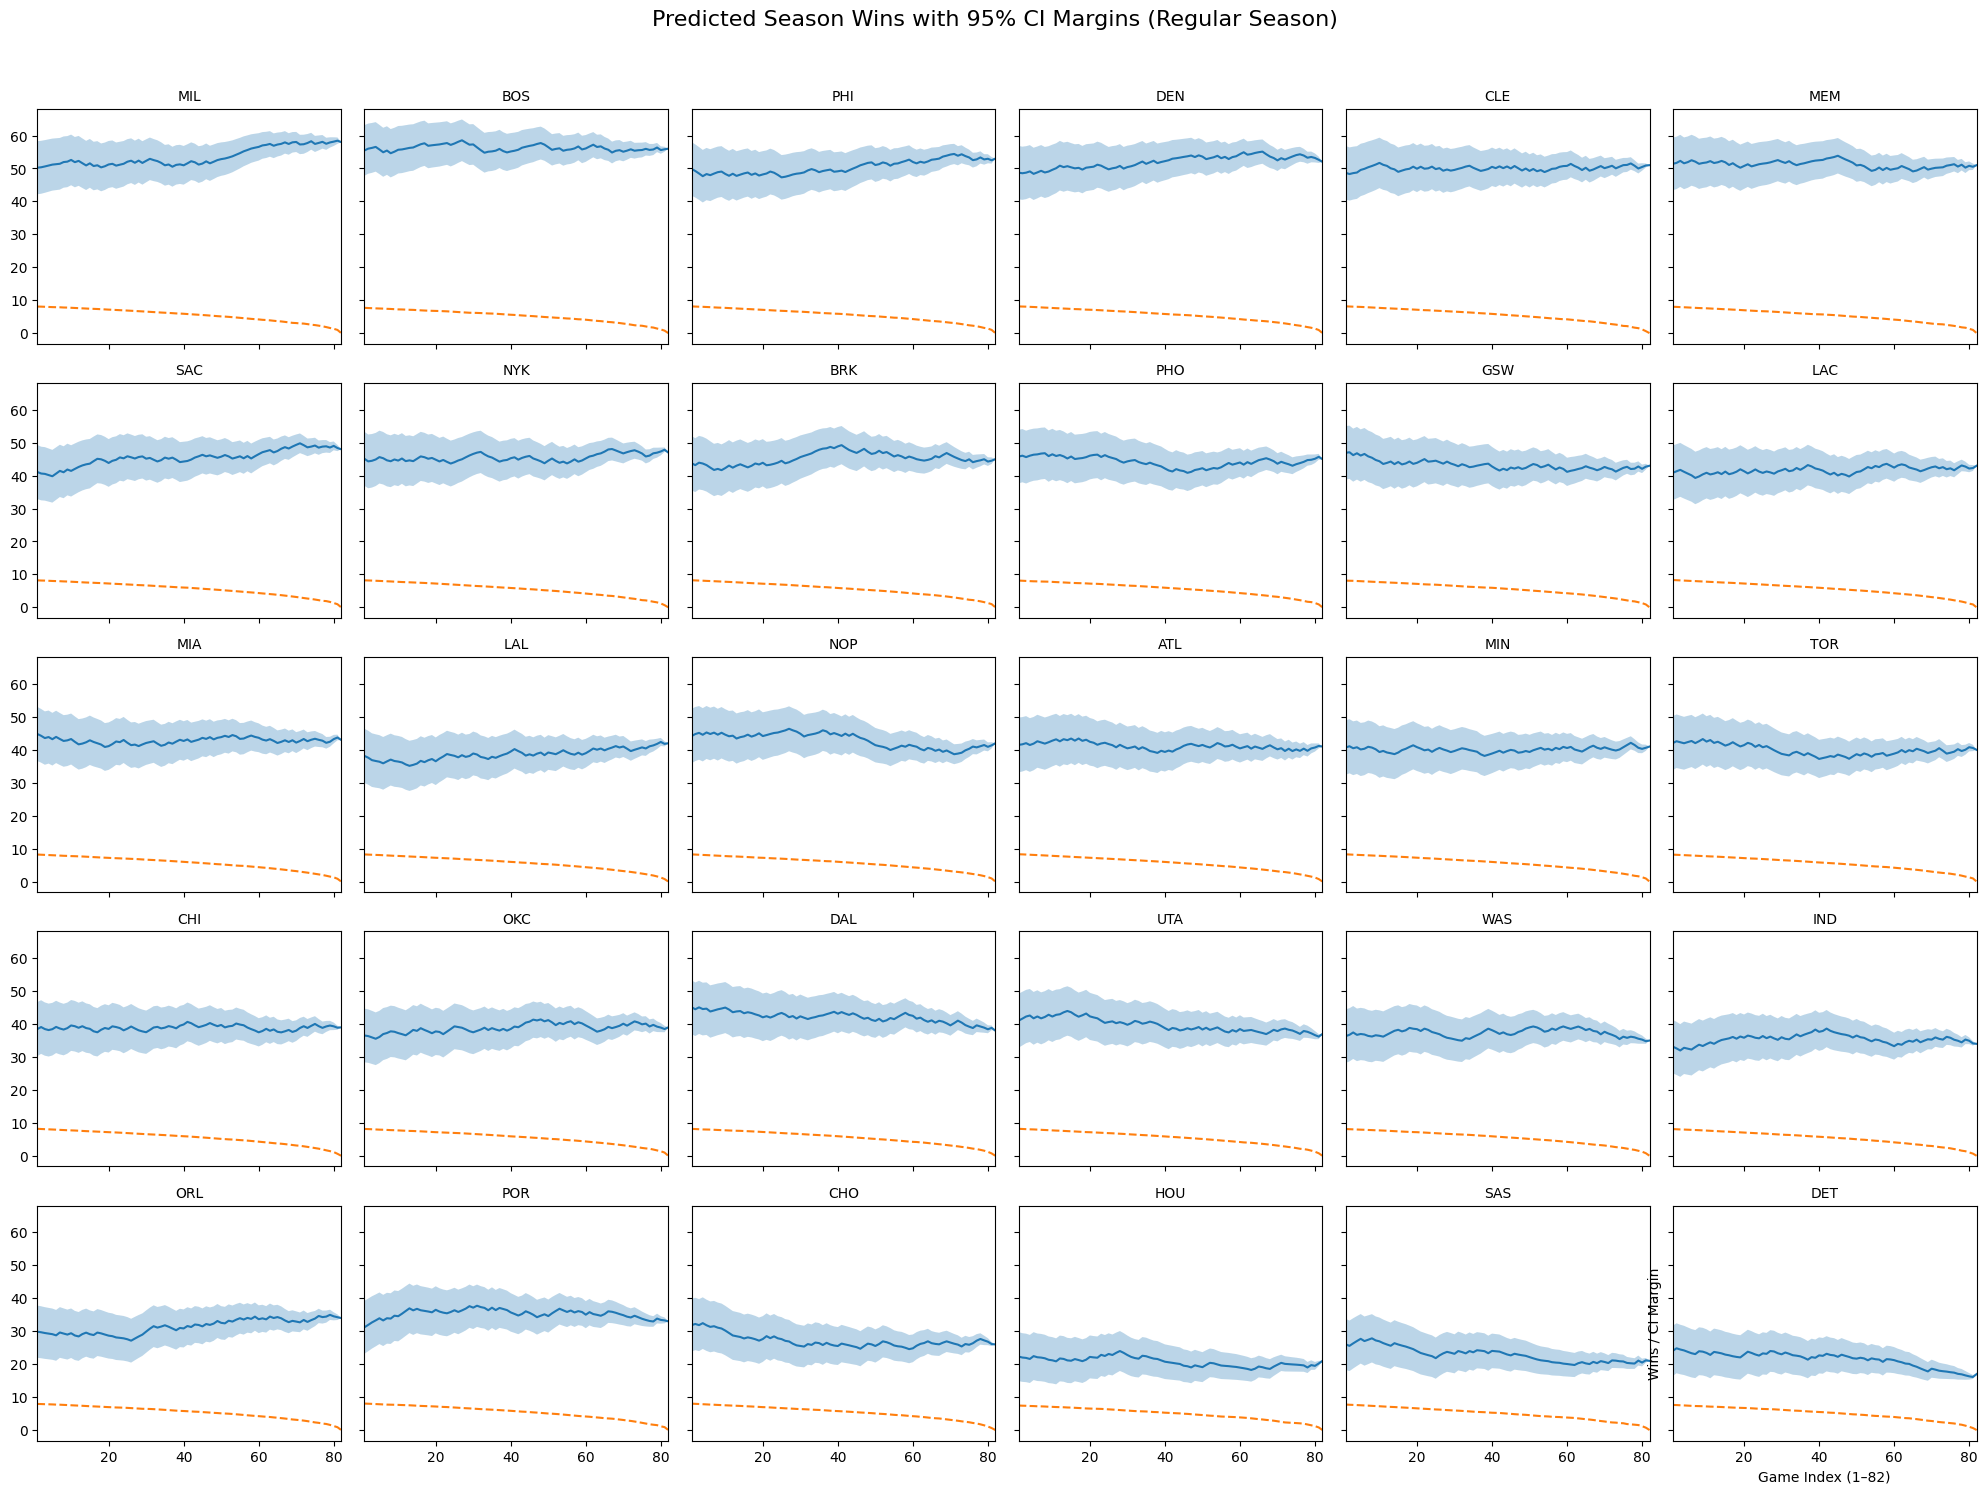

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# 1. Load the forecast data (ensure 'nba_elo_latest.csv' is in your working directory)
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])

# 2. Prepare per-team game-level data
games = pd.concat([
    df.rename(columns={'team1': 'team', 'elo_prob1': 'win_prob', 'score1': 'score', 'score2': 'opp_score'}),
    df.rename(columns={'team2': 'team', 'elo_prob2': 'win_prob', 'score2': 'score', 'score1': 'opp_score'})
], ignore_index=True).sort_values(['team', 'date']).reset_index(drop=True)
games['actual_win'] = (games['score'] > games['opp_score']).astype(int)

# 3. Function to compute predictions and CI margins up to 82 games
def team_stats(team, max_games=82, z=1.96):
    grp = games[games['team'] == team].reset_index(drop=True)
    stats = []
    wins_so_far = 0
    for i in range(min(len(grp), max_games)):
        if i > 0:
            wins_so_far += grp.loc[i-1, 'actual_win']
        future = grp.loc[i+1:max_games-1, 'win_prob']
        exp_rem_wins = future.sum()
        var_rem = (future * (1 - future)).sum()
        pred_wins = wins_so_far + exp_rem_wins
        ci_margin = z * sqrt(var_rem)
        stats.append({
            'game_idx': i + 1,
            'predicted_wins': pred_wins,
            'ci_margin': ci_margin
        })
    return pd.DataFrame(stats)

# 4. Determine ordering by final predicted wins (game 82)
teams = sorted(games['team'].unique())
final_wins = [(team, team_stats(team).loc[81, 'predicted_wins']) for team in teams]
sorted_teams = [team for team, _ in sorted(final_wins, key=lambda x: x[1], reverse=True)]

# 5. Create grid of subplots
n_teams = len(sorted_teams)
cols = 6
rows = n_teams // cols + int(n_teams % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.flatten()

# 6. Plot each team's predicted wins, CI band, and margin
for ax, team in zip(axes, sorted_teams):
    stats_df = team_stats(team)
    ax.plot(stats_df['game_idx'], stats_df['predicted_wins'])
    ax.fill_between(
        stats_df['game_idx'],
        stats_df['predicted_wins'] - stats_df['ci_margin'],
        stats_df['predicted_wins'] + stats_df['ci_margin'],
        alpha=0.3
    )
    ax.plot(stats_df['game_idx'], stats_df['ci_margin'], linestyle='--')
    ax.set_title(team, fontsize=10)
    ax.set_xlim(1, 82)

# 7. Remove any unused subplots
for j in range(len(sorted_teams), len(axes)):
    fig.delaxes(axes[j])

# 8. Overall layout adjustments
fig.suptitle('Predicted Season Wins with 95% CI Margins (Regular Season)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.xlabel('Game Index (1–82)')
plt.ylabel('Wins / CI Margin')
plt.show()


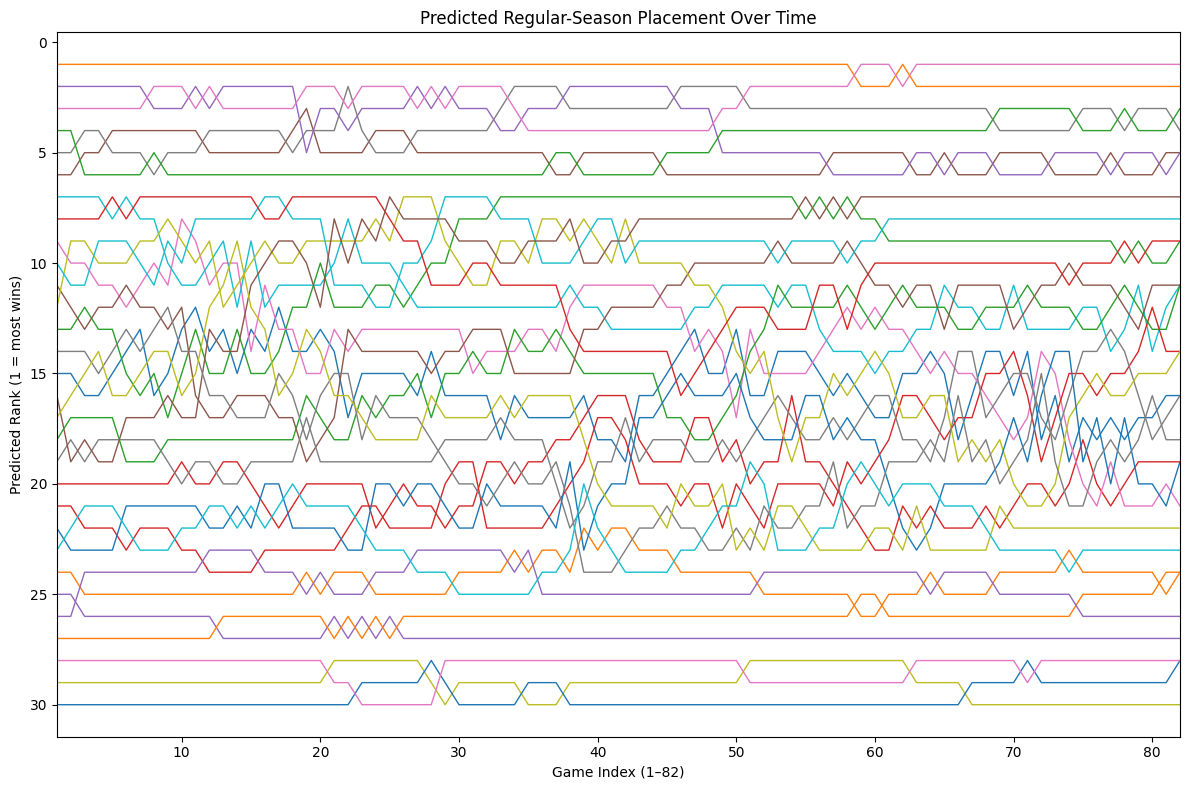

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# 1. Load the forecast data (ensure 'nba_elo_latest.csv' is in your working directory)
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])

# 2. Prepare per-team game-level data
games = pd.concat([
    df.rename(columns={'team1': 'team', 'elo_prob1': 'win_prob', 'score1': 'score', 'score2': 'opp_score'}),
    df.rename(columns={'team2': 'team', 'elo_prob2': 'win_prob', 'score2': 'score', 'score1': 'opp_score'})
], ignore_index=True).sort_values(['team', 'date']).reset_index(drop=True)
games['actual_win'] = (games['score'] > games['opp_score']).astype(int)

# 3. Compute predicted wins for each team & game index up to 82
results = []
for team, grp in games.groupby('team'):
    grp = grp.reset_index(drop=True)
    wins_so_far = 0
    for i in range(min(len(grp), 82)):
        if i > 0:
            wins_so_far += grp.loc[i-1, 'actual_win']
        future = grp.loc[i+1:81, 'win_prob']
        exp_rem_wins = future.sum()
        pred_win = wins_so_far + exp_rem_wins
        results.append({'team': team, 'game_idx': i+1, 'predicted_wins': pred_win})

pred_df = pd.DataFrame(results)

# 4. Pivot to wide format
pivot = pred_df.pivot(index='game_idx', columns='team', values='predicted_wins')

# 5. Compute rank (1 = highest predicted wins)
rank_df = pivot.rank(axis=1, ascending=False, method='min').astype(int)

# 6. Plot rank over time for all teams
plt.figure(figsize=(12, 8))
for team in rank_df.columns:
    plt.plot(rank_df.index, rank_df[team], linewidth=1)

plt.gca().invert_yaxis()  # rank 1 at top
plt.xlim(1, 82)
plt.xlabel('Game Index (1–82)')
plt.ylabel('Predicted Rank (1 = most wins)')
plt.title('Predicted Regular-Season Placement Over Time')
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
from math import sqrt

# 1. Load the forecast data
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])

# 2. Prepare per-team game-level data
games = pd.concat([
    df.rename(columns={'team1': 'team', 'elo_prob1': 'win_prob', 'score1': 'score', 'score2': 'opp_score'}),
    df.rename(columns={'team2': 'team', 'elo_prob2': 'win_prob', 'score2': 'score', 'score1': 'opp_score'})
], ignore_index=True).sort_values(['team', 'date']).reset_index(drop=True)
games['actual_win'] = (games['score'] > games['opp_score']).astype(int)

# 3. Compute team-level predictions with CI margins up to 82 games
def team_stats(team, max_games=82, z=1.96):
    grp = games[games['team'] == team].reset_index(drop=True)
    stats = []
    wins_so_far = 0
    for i in range(min(len(grp), max_games)):
        if i > 0:
            wins_so_far += grp.loc[i-1, 'actual_win']
        future = grp.loc[i+1:max_games-1, 'win_prob']
        exp_rem_wins = future.sum()
        var_rem = (future * (1 - future)).sum()
        ci_margin = z * sqrt(var_rem)
        stats.append({
            'team': team,
            'game_idx': i + 1,
            'predicted_wins': wins_so_far + exp_rem_wins,
            'ci_margin': ci_margin
        })
    return pd.DataFrame(stats)

# 4. Order teams by final predicted wins at game 82
teams = sorted(games['team'].unique())
final_wins = [(team, team_stats(team).loc[81, 'predicted_wins']) for team in teams]
sorted_teams = [team for team, _ in sorted(final_wins, key=lambda x: x[1], reverse=True)]

# 5. Aggregate all team stats into one DataFrame
all_stats = pd.concat([team_stats(team) for team in sorted_teams], ignore_index=True)

# 6. Save to CSV
output_path = 'predicted_wins_ci.csv'
all_stats.to_csv(output_path, index=False)
print(f'Saved combined data to {output_path}')

Saved combined data to predicted_wins_ci.csv
